<a href="https://colab.research.google.com/github/snripesh/PythonProject/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install newspaper3k

In [ ]:
!pip install catboost

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.decomposition import PCA
import seaborn as sns
from newspaper import Article
import requests
from bs4 import BeautifulSoup
import io

In [6]:
from google.colab import files
uploaded = files.upload()

Saving OnlineNewsPopularity.csv to OnlineNewsPopularity.csv


In [7]:
data = pd.read_csv(io.BytesIO(uploaded['OnlineNewsPopularity.csv']))

In [8]:
def cleancols(cols):
    x = [y.lower().strip() for y in cols]
    return x

In [9]:
data.columns = cleancols(data.columns)
y_labels = data['shares'] #the feature to be predicted
df = data.drop(columns = ['url','timedelta','shares'],axis = 1) #url and timedelta are of no use to us

In [10]:
url = "https://www.bbc.com/news/world"
page = requests.get(url)
soup = BeautifulSoup(page.content,'html.parser')
imgnews = soup.findAll('a',attrs = {'class':'gs-c-promo-heading gs-o-faux-block-link__overlay-link gel-pica-bold nw-o-link-split__anchor'})

In [11]:
newsarts = []
for arts in imgnews:
    newsarts.append("https://www.bbc.com"+arts['href'])

In [12]:
pca = PCA(n_components = 12)
df_scaled = pd.DataFrame(preprocessing.scale(df),columns = df.columns)
df_red = pca.fit_transform(df_scaled) #applying PCA on the standardized data
explainedfeats = pd.DataFrame(pca.components_,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10','PC-11','PC-12'],columns = df.columns)

[03:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


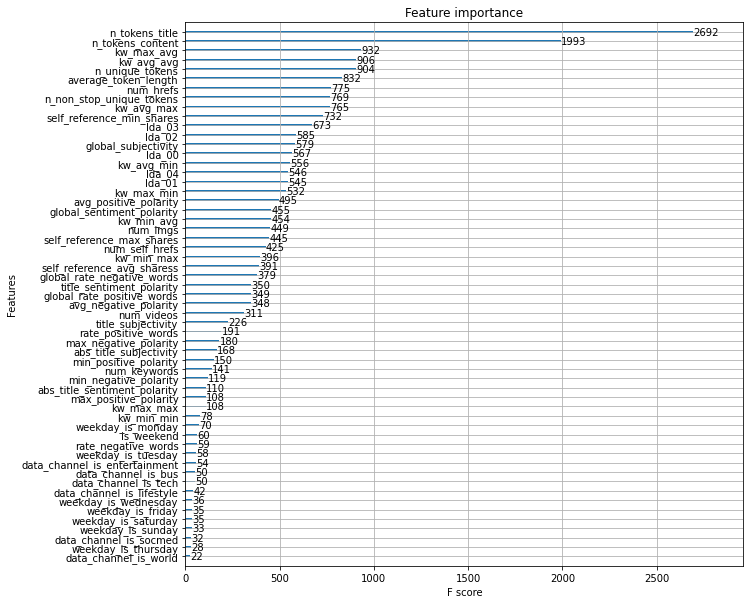

In [13]:
xgb = XGBRegressor(max_depth = 10,random_state = 42)
xgb.fit(df,y_labels)
fig, ax = plt.subplots(1,1,figsize=(10,10))
impplot = plot_importance(xgb,ax = ax)
plt.show()

In [14]:
impfeats = [impplot.get_yticklabels()[::-1][i].get_text() for i in range(0,20)]
print(impfeats)

['n_tokens_title', 'n_tokens_content', 'kw_max_avg', 'kw_avg_avg', 'n_unique_tokens', 'average_token_length', 'num_hrefs', 'n_non_stop_unique_tokens', 'kw_avg_max', 'self_reference_min_shares', 'lda_03', 'lda_02', 'global_subjectivity', 'lda_00', 'kw_avg_min', 'lda_04', 'lda_01', 'kw_max_min', 'avg_positive_polarity', 'global_sentiment_polarity']


In [15]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))
from textblob import TextBlob #for subjectivity and polarity purpose

In [17]:
def tokenizetext(text):
    return word_tokenize(text)
def words(text):
    l = [word for word in word_tokenize(text) if word.isalpha()]
    return l
def unique_words(text):
    return list(set(words(text)))
def rate_uni_words(text):
    uni_words = len(unique_words(text))/len(words(text))
    return uni_words
def avglengthtoken(text):
    w = words(text)
    sum = 0
    for item in w:
        sum+=len(item)
    avglen = sum/len(w)
    return avglen
def n_non_stop_unique_tokens(text):
    uw = unique_words(text)
    n_uw = [item for item in uw if item not in stopwords]
    w = words(text)
    n_w = [item for item in w if item not in stopwords]
    rate_nsut = len(n_uw)/len(n_w)
    return rate_nsut
def numlinks(article):
    return len(BeautifulSoup(sampletext.html).findAll('link'))
def get_subjectivity(a_text):
    return a_text.sentiment.subjectivity
def get_polarity(a_text):
    return a_text.sentiment.polarity
def word_polarity(words):
    pos_words = []
    ppos_words = [] # polarity of pos words
    neg_words = []
    pneg_words = [] # polarity of negative words
    neu_words = []
    pneu_words = [] # polarity of neutral words
    for w in words:
        an_word = TextBlob(w)
        val = an_word.sentiment.polarity
        if val > 0:
            pos_words.append(w)
            ppos_words.append(val)
        if val < 0:
            neg_words.append(w)
            pneg_words.append(val)
        if val == 0 :
            neu_words.append(w)
            pneu_words.append(val)
    return pos_words,ppos_words,neg_words,pneg_words,neu_words,pneu_words
def avg_pol_pw(text):    
    totalwords = words(text)
    res = word_polarity(totalwords)
    return np.sum(res[1])/len(res[0])
def avg_pol_nw(text):    
    totalwords = words(text)
    res = word_polarity(totalwords)
    return np.sum(res[3])/len(res[2])

In [18]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
finrows = []
for article in newsarts[0:25]:
    sampletext = Article(article, language = 'en')
    sampletext.download()
    sampletext.parse()
    sampletext.nlp() 
    
    row = {}
    row['n_tokens_title'] = len(words(sampletext.title))
    row['n_tokens_content'] = len(words(sampletext.text))
    row['n_unique_tokens'] = len(unique_words(sampletext.text))
    row['average_token_length'] = avglengthtoken(sampletext.text)
    row['n_non_stop_unique_tokens'] = n_non_stop_unique_tokens(sampletext.text)
    row['num_hrefs'] = numlinks(sampletext)
    
    analysed_text = TextBlob(sampletext.text)
    row['global_subjectivity'] = get_subjectivity(analysed_text)
    row['avg_positive_polarity'] = avg_pol_pw(sampletext.text)
    row['global_sentiment_polarity'] = get_polarity(analysed_text)
    finrows.append(row)
#converting the list to a dataframe
masterdf = pd.DataFrame(finrows, columns = ['n_tokens_title','n_tokens_content','n_unique_tokens','average_token_length','n_non_stop_unique_tokens','num_hrefs','global_subjectivity',
                                   'avg_positive_polarity','global_sentiment_polarity'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


In [56]:
np.any(np.isnan(masterdf))

True

In [20]:
df_reduced = df[masterdf.columns]

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(df_reduced, y_labels, test_size = 0.2, shuffle = True, random_state = 42)

In [22]:
xgb2 = XGBRegressor(random_state = 42)
paramsxgb = {'max_depth':[5,20,50,100]}
gsc = GridSearchCV(estimator = xgb2,param_grid = paramsxgb, cv = 3, scoring = 'neg_root_mean_squared_error')
gscres = gsc.fit(xtrain,ytrain)
gscres.best_params_

[03:29:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:30:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

{'max_depth': 5}

In [23]:
xgb2.max_depth = gscres.best_params_['max_depth']
boost = ['gbtree','gblinear']
rmsescores = {}
for b in boost:
    xgb2.booster = b
    xgb2.fit(xtrain,ytrain)
    predicted = xgb2.predict(xtest)
    rmsescores['xgb-'+b] = RMSE(ytest,predicted,squared = False)
    print("RMSE error with {} booster is {} :".format(b,RMSE(ytest,predicted,squared = False)))

[03:33:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE error with gbtree booster is 11075.818508248849 :
[03:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE error with gblinear booster is 10978.23531369271 :


In [24]:
xgb2.booster = 'gblinear'

In [25]:
rf = RandomForestRegressor(random_state = 42)
paramsrf = {'max_depth':[5,20,50,100]}
gsc = GridSearchCV(estimator = rf,param_grid = paramsrf, cv = 3, scoring = 'neg_root_mean_squared_error')
gscres = gsc.fit(xtrain,ytrain)
gscres.best_params_

{'max_depth': 5}

In [26]:
rf.max_depth = gscres.best_params_['max_depth']
rf.fit(xtrain,ytrain)
predictedrf = rf.predict(xtest)
rmsescores['rf'] = RMSE(ytest,predictedrf,squared = False)
print("RMSE error with Random Forest Regressor is {} :".format(RMSE(ytest,predicted,squared = False)))

RMSE error with Random Forest Regressor is 10978.23531369271 :


In [27]:
lr = RidgeCV(alphas = [0.001,0.1,1,5,10,100],scoring = 'neg_root_mean_squared_error', cv = None, store_cv_values = True)
lr.fit(xtrain,ytrain)

RidgeCV(alphas=array([1.e-03, 1.e-01, 1.e+00, 5.e+00, 1.e+01, 1.e+02]),
        scoring='neg_root_mean_squared_error', store_cv_values=True)

In [28]:
predictedlr = lr.predict(xtest)
rmsescores['ridgecv'] = RMSE(ytest,predictedlr,squared = False)
print("RMSE error with Linear Regression via RidgeCV is {} :".format(RMSE(ytest,predictedlr,squared = False)))

RMSE error with Linear Regression via RidgeCV is 10952.05810736365 :


In [29]:
cb = CatBoostRegressor(verbose = 0,random_state = 42,eval_metric = 'RMSE')
paramscb = {'iterations':[1,10,50,100],'learning_rate':[0.03,0.1,0.5,1],'depth':[3,5,8,10]}
gsc = GridSearchCV(estimator = cb,param_grid = paramscb, cv = 3, scoring = 'neg_root_mean_squared_error')
gscres = gsc.fit(xtrain,ytrain)
gscres.best_params_

{'depth': 10, 'iterations': 100, 'learning_rate': 0.03}

In [30]:
cb.iterations = gscres.best_params_['iterations']
cb.learning_rate = gscres.best_params_['learning_rate']
cb.depth = gscres.best_params_['depth']
cb.fit(xtrain,ytrain)

In [31]:
predictedcb = cb.predict(xtest)
rmsescores['catboost'] = RMSE(ytest,predictedcb,squared = False)
print("RMSE error with CatBoost is {} :".format(RMSE(ytest,predictedcb,squared = False)))

RMSE error with CatBoost is 11308.71909240918 :


In [ ]:
pip install -U scikit-learn

In [62]:
np.all(np.isfinite(masterdf))

False

In [72]:
masterdf.replace([np.inf, -np.inf], np.nan, inplace=True)
masterdf.fillna(masterdf.mean(), inplace=True)
predlr = lr.predict(masterdf)
lrdata = {'Links':list(newsarts[:25]),'Predicted Virality':list(predlr)}
pd.DataFrame(lrdata).reindex(np.arange(0,25,1))


,Links,Predicted Virality
0,https://www.bbc.com/news/world-asia-india-5983...,6.275222e+04
1,https://www.bbc.com/news/world-europe-59871779,7.387447e+04
2,https://www.bbc.com/news/world-australia-59876203,5.948864e+04
3,https://www.bbc.com/news/world-asia-59876095,5.037410e+04
4,https://www.bbc.com/news/world-latin-america-5...,4.613880e+04
5,https://www.bbc.com/news/world-us-canada-59876423,1.260703e+05
6,https://www.bbc.com/news/world-asia-india-5983...,6.275222e+04
7,https://www.bbc.com/news/world-europe-59871779,7.387447e+04
8,https://www.bbc.com/news/world-australia-59876203,5.948864e+04
9,https://www.bbc.com/news/world-asia-59876095,5.037410e+04


In [73]:
predcb = cb.predict(masterdf)
cbdata = {'Links':list(newsarts[0:25]),'Predicted Virality':list(predcb)}
pd.DataFrame(cbdata).reindex(np.arange(0,25,1))

,Links,Predicted Virality
0,https://www.bbc.com/news/world-asia-india-5983...,1651.720567
1,https://www.bbc.com/news/world-europe-59871779,662.308598
2,https://www.bbc.com/news/world-australia-59876203,3866.478567
3,https://www.bbc.com/news/world-asia-59876095,1219.957718
4,https://www.bbc.com/news/world-latin-america-5...,1070.431904
5,https://www.bbc.com/news/world-us-canada-59876423,2980.590227
6,https://www.bbc.com/news/world-asia-india-5983...,1651.720567
7,https://www.bbc.com/news/world-europe-59871779,662.308598
8,https://www.bbc.com/news/world-australia-59876203,3866.478567
9,https://www.bbc.com/news/world-asia-59876095,1219.957718


In [74]:
predrf = rf.predict(masterdf)
rfdata = {'Links':list(newsarts[0:25]),'Predicted Virality':list(predrf)}
pd.DataFrame(rfdata).reindex(np.arange(0,25,1))

,Links,Predicted Virality
0,https://www.bbc.com/news/world-asia-india-5983...,3892.239083
1,https://www.bbc.com/news/world-europe-59871779,3415.447174
2,https://www.bbc.com/news/world-australia-59876203,4571.596307
3,https://www.bbc.com/news/world-asia-59876095,5131.730502
4,https://www.bbc.com/news/world-latin-america-5...,3465.381411
5,https://www.bbc.com/news/world-us-canada-59876423,3436.681430
6,https://www.bbc.com/news/world-asia-india-5983...,3892.239083
7,https://www.bbc.com/news/world-europe-59871779,3415.447174
8,https://www.bbc.com/news/world-australia-59876203,4571.596307
9,https://www.bbc.com/news/world-asia-59876095,5131.730502


In [75]:
predxgb = xgb2.predict(masterdf)
xgbdata = {'Links':list(newsarts[0:25]),'Predicted Virality':list(predxgb)}
pd.DataFrame(xgbdata).reindex(np.arange(0,25,1))

,Links,Predicted Virality
0,https://www.bbc.com/news/world-asia-india-5983...,3161.249023
1,https://www.bbc.com/news/world-europe-59871779,3311.295898
2,https://www.bbc.com/news/world-australia-59876203,3053.013184
3,https://www.bbc.com/news/world-asia-59876095,2873.659424
4,https://www.bbc.com/news/world-latin-america-5...,3035.470703
5,https://www.bbc.com/news/world-us-canada-59876423,3037.714844
6,https://www.bbc.com/news/world-asia-india-5983...,3161.249023
7,https://www.bbc.com/news/world-europe-59871779,3311.295898
8,https://www.bbc.com/news/world-australia-59876203,3053.013184
9,https://www.bbc.com/news/world-asia-59876095,2873.659424
